# Clustering Universities by Financial Return on Investment

This notebook explores clustering methods to group universities based on their financial return on investment (ROI) using data from the College Scorecard.

## 1. Setup & Data Loading

First, we import the necessary Python libraries for data analysis, machine learning, and visualization. We'll then load the College Scorecard dataset.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [15]:
try:
    file_path = '../data/raw/most-recent-cohorts-institution.csv'
    missing_values = ["PrivacySuppressed", "NULL", "PS"]
    df_raw = pd.read_csv(file_path, na_values=missing_values)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}.")
    print("Please make sure the 'most-recent-cohorts-institution.csv' file is in the 'data/raw/' directory.")
    df_raw = pd.DataFrame() # Create empty dataframe to prevent further errors

# Display the first few rows to understand the structure
if not df_raw.empty:
    display(df_raw.head())

Dataset loaded successfully.
Shape of the dataset: (6429, 3306)


/var/folders/2q/nzhd0ryn6nz37r6nt56sq0dm0000gp/T/ipykernel_97503/2798358810.py:4: DtypeWarning: Columns (9,1729,1743,1909,1910,1911,1912,1913,2197,2198,2200,2201,2202,2203,2204,2206,2207,2208,2209,2210,2211,2212,2213,2215,2216,2217,2218,2219,2220,2221,2222,2251,2252,2253,2254,2255,2256,2257,2258,2278,2279,2280,2281,2282,2283,2284,2285,2296,2297,2298,2299,2300,2301,2302,2303,2305,2306,2307,2308,2309,2310,2311,2312,2314,2315,2316,2317,2318,2319,2320,2321,2350,2351,2352,2353,2354,2355,2356,2357,2712,2713,2715,2716,2717,2718,2719,2721,2722,2724,2725,2726,2727,2728,2767,2768,2769,2770,2771,2772,2773,2784,2785,2786,2787,2788,2789,2790,2791,2793,2794,2795,2796,2797,2798,2799,2800,2802,2803,2804,2805,2806,2807,2808,2809,2820,2821,2822,2823,2824,2825,2826,2827,2838,2839,2840,2841,2842,2843,2844,2845,2919,2920,2922,2923,2924,2925,2926,2928,2929,2931,2932,2933,2934,2935,2937,2938,2939,2940,2941,2942,2943,2944,2946,2947,2948,2949,2950,2951,2952,2953,3027,3029,3030,3031,3032,3033,3044,3045,3046,304

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## 2. Exploratory Data Analysis (EDA)

Before we start clustering, we need to understand the data. We'll look at the distribution of our key variables and their relationships.

Based on our project proposal, we're interested in cost, debt, and earnings.
Let's select these key features and give them more readable names.

- `COSTT4_A`: Average cost of attendance (academic year institutions)
- `DEBT_MDN`: The median original principal loan amount of all undergraduate borrowers of federal loans
- `MD_EARN_WNE_P8`: Median earnings of students working and not enrolled 8 years after entry
- `ADM_RATE`: Admission rate
- `CONTROL`: Control of institution (1: Public, 2: Private nonprofit, 3: Private for-profit)

Summary statistics of key features:


,AvgCost,MedianDebt,MedianEarnings,AdmissionRate,ControlType
count,3247.000000,5283.000000,5383.000000,1946.000000,6429.000000
mean,30270.544195,11268.762446,40480.766859,0.727594,2.056618
std,18375.779152,5190.790837,15823.768394,0.229527,0.832540
min,4274.000000,1932.000000,7811.000000,0.000000,1.000000
25%,15765.000000,7000.000000,29749.000000,0.603975,1.000000
50%,24517.000000,9500.000000,37963.000000,0.779150,2.000000
75%,40135.500000,15000.000000,48433.500000,0.908175,3.000000
max,87804.000000,38980.000000,147923.000000,1.000000,3.000000


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msd

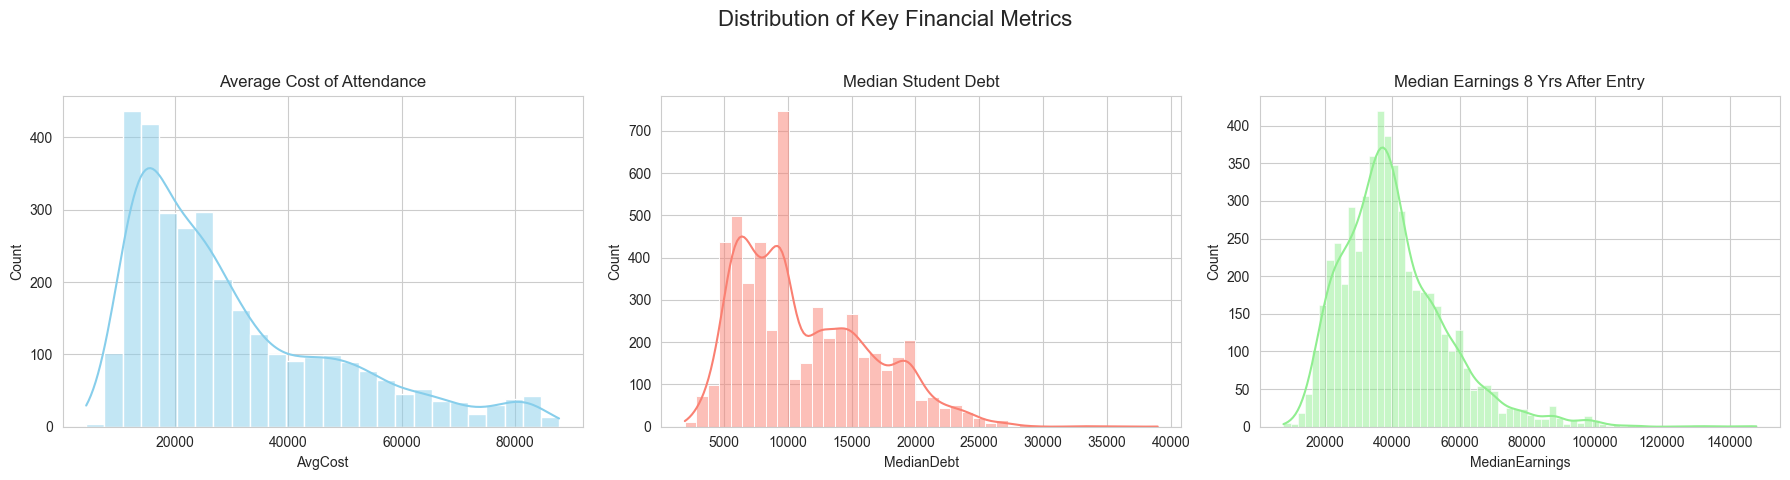


Pairwise relationships between features:


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3430: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3430: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3430: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/seaborn/regression.py:255: RuntimeWarning: divide by zero encountered in dot
  yhat_boots = grid.dot(beta_boots).T
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/seaborn/regression.py:255: RuntimeWarning: overflow encountered in dot
  yhat_boots = grid.dot(beta_boots).T
/Users/belewis/msds

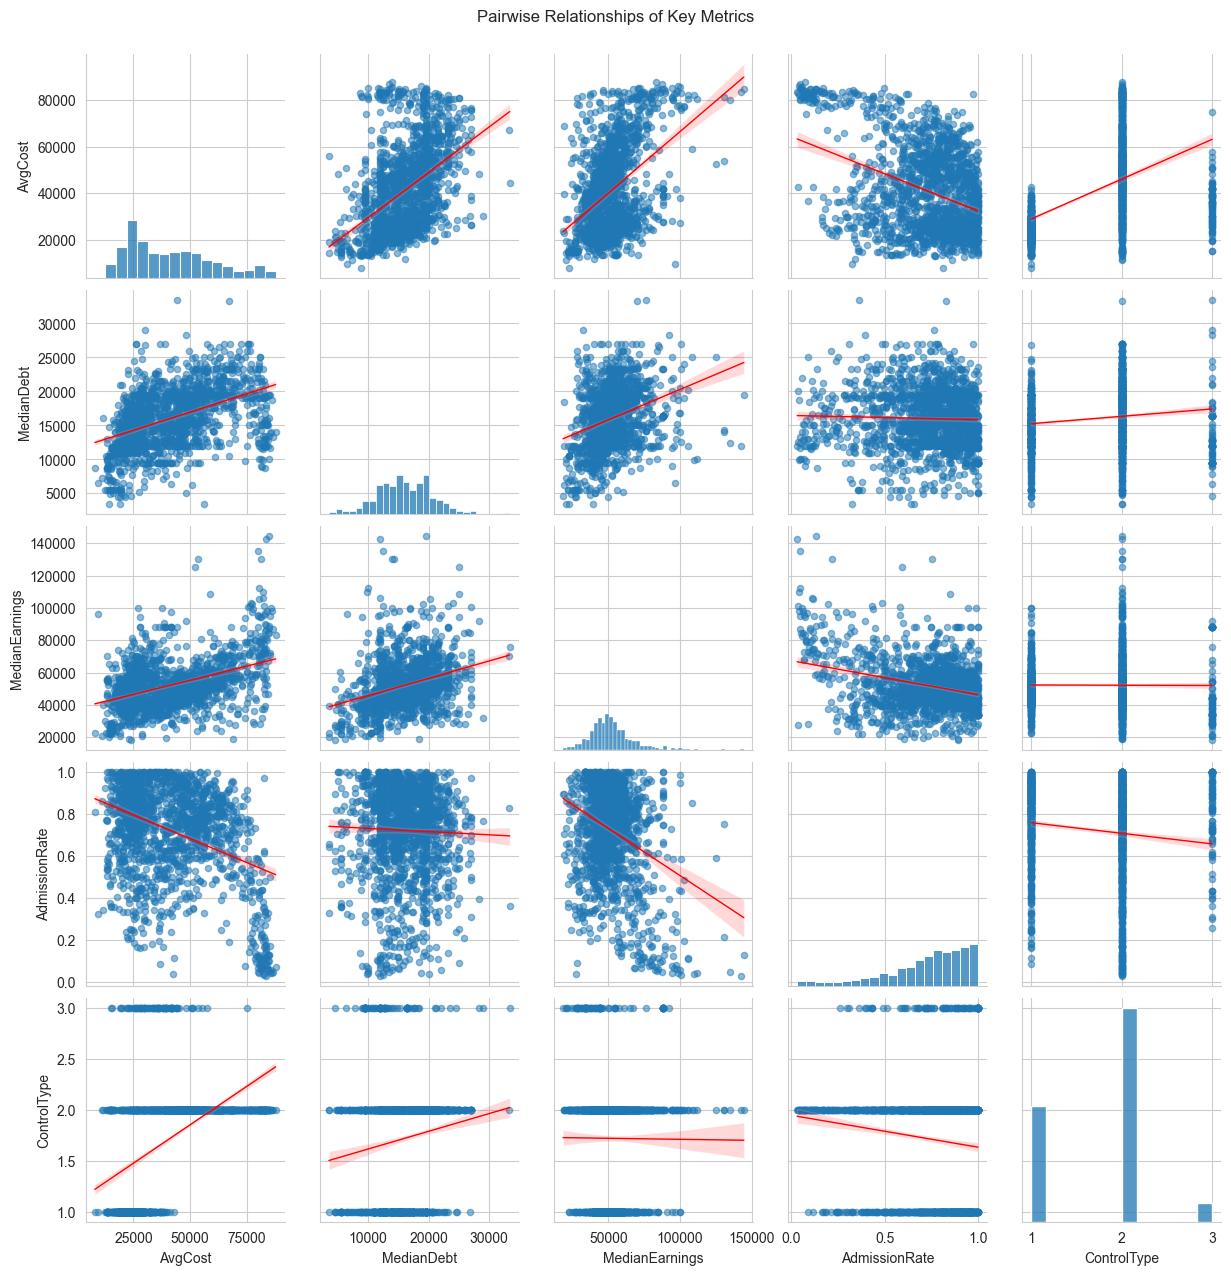

In [16]:
feature_map = {
    'INSTNM': 'InstitutionName',
    'COSTT4_A': 'AvgCost',
    'DEBT_MDN': 'MedianDebt',
    'MD_EARN_WNE_P8': 'MedianEarnings',
    'ADM_RATE': 'AdmissionRate',
    'CONTROL': 'ControlType'
}

# Select only the columns we need
df_eda = df_raw[list(feature_map.keys())].copy()
df_eda.rename(columns=feature_map, inplace=True)

# Display summary statistics for our key features
if not df_eda.empty:
    print("Summary statistics of key features:")
    display(df_eda.describe())

# Visualize the distributions of the key numerical features
if not df_eda.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Distribution of Key Financial Metrics', fontsize=16)

    sns.histplot(df_eda['AvgCost'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Average Cost of Attendance')

    sns.histplot(df_eda['MedianDebt'], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Median Student Debt')

    sns.histplot(df_eda['MedianEarnings'], kde=True, ax=axes[2], color='lightgreen')
    axes[2].set_title('Median Earnings 8 Yrs After Entry')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize the relationship between features using a pairplot
if not df_eda.empty:
    print("\nPairwise relationships between features:")
    # We'll drop rows with missing values for this plot to get a clean visualization
    sns.pairplot(df_eda.dropna(), kind='reg', plot_kws={'line_kws':{'color':'red', 'lw':1}, 'scatter_kws': {'alpha': 0.5, 's': 20}})
    plt.suptitle('Pairwise Relationships of Key Metrics', y=1.02)
    plt.show()

## 3. Feature Selection & Preprocessing

Now, we prepare the data for the clustering algorithm. This involves:
1. Selecting our final features for clustering.
2. Converting columns to numeric types, forcing errors.
3. Handling missing values.
4. Scaling the features so they are on a comparable scale.

In [17]:
df_processed = df_eda.dropna(subset=['AvgCost', 'MedianDebt', 'MedianEarnings']).copy()

print(f"Original number of institutions: {len(df_eda)}")
print(f"Number of institutions after dropping missing values: {len(df_processed)}")
print(f"Percentage of data kept: {len(df_processed) / len(df_eda) * 100:.2f}%")

# Select the final features for clustering
features_for_clustering = ['AvgCost', 'MedianDebt', 'MedianEarnings']
X = df_processed[features_for_clustering]

# Standardize the features
# K-Means is distance-based, so it's crucial that all features are on the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData has been preprocessed and is ready for clustering.")
print(f"Shape of scaled data: {X_scaled.shape}")


Original number of institutions: 6429
Number of institutions after dropping missing values: 2903
Percentage of data kept: 45.15%

Data has been preprocessed and is ready for clustering.
Shape of scaled data: (2903, 3)


## 4. K-Means Clustering & Model Selection

We will now apply the K-Means algorithm. A key part of using K-Means is choosing the right number of clusters (`k`). We'll use the Silhouette Score to help us make this decision.

We'll test a range of k values and calculate the silhouette score for each.
A higher silhouette score indicates better-defined clusters.

For k=2, Silhouette Score: 0.4488, Inertia: 4325.42
For k=3, Silhouette Score: 0.3933, Inertia: 3120.68
For k=4, Silhouette Score: 0.3778, Inertia: 2549.41


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-d

For k=5, Silhouette Score: 0.3667, Inertia: 2155.88
For k=6, Silhouette Score: 0.3423, Inertia: 1948.20
For k=7, Silhouette Score: 0.3423, Inertia: 1784.87
For k=8, Silhouette Score: 0.3465, Inertia: 1618.55
For k=9, Silhouette Score: 0.3337, Inertia: 1489.11
For k=6, Silhouette Score: 0.3423, Inertia: 1948.20
For k=7, Silhouette Score: 0.3423, Inertia: 1784.87
For k=8, Silhouette Score: 0.3465, Inertia: 1618.55
For k=9, Silhouette Score: 0.3337, Inertia: 1489.11


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-d

For k=10, Silhouette Score: 0.2663, Inertia: 1400.09


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extm

For k=11, Silhouette Score: 0.2610, Inertia: 1321.13
For k=12, Silhouette Score: 0.2701, Inertia: 1266.00
For k=13, Silhouette Score: 0.2693, Inertia: 1179.49
For k=14, Silhouette Score: 0.2706, Inertia: 1116.83
For k=15, Silhouette Score: 0.2690, Inertia: 1082.43
For k=15, Silhouette Score: 0.2690, Inertia: 1082.43


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-d

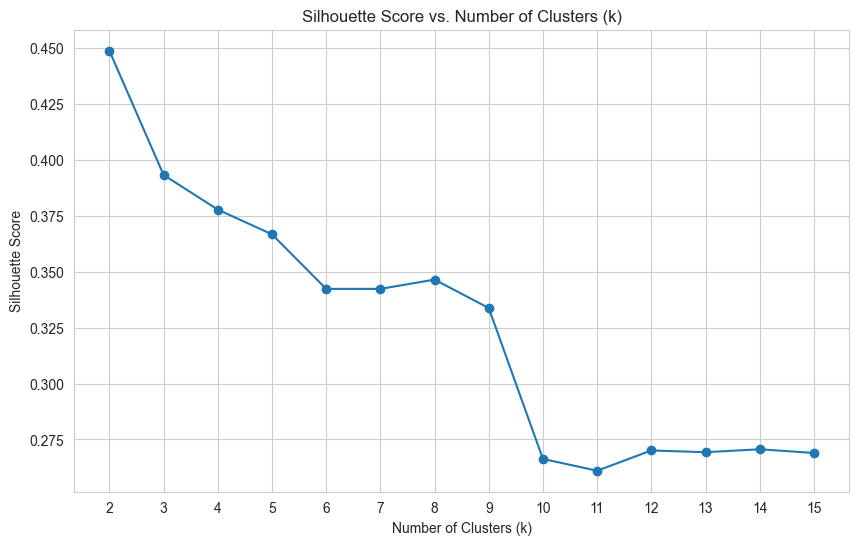


Based on the silhouette score, the optimal number of clusters is: 2


In [18]:
k_range = range(2, 16) # Test k from 2 to 15
silhouette_scores = []
inertia_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    
    # Also store inertia (sum of squared distances to closest centroid)
    inertia_scores.append(kmeans.inertia_)
    print(f"For k={k}, Silhouette Score: {score:.4f}, Inertia: {kmeans.inertia_:.2f}")

# Plot the Silhouette Scores to find the optimal k
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# The "best" k is often the one with the highest silhouette score.
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nBased on the silhouette score, the optimal number of clusters is: {optimal_k}")

## 5. Cluster Analysis & Profiling

Now that we've chosen an optimal `k`, we'll run K-Means one last time and analyze the resulting clusters.

Data with assigned clusters:


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-d

,InstitutionName,AvgCost,MedianDebt,MedianEarnings,AdmissionRate,ControlType,Cluster
0,Alabama A & M University,23751.0,16600.0,31992.0,0.6622,1,1
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,0.8842,1,0
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,0.7425,1,0
4,Alabama State University,22028.0,17500.0,32520.0,0.9564,1,1
5,The University of Alabama,32024.0,17986.0,56012.0,0.7582,1,0



Cluster Profiles (mean values for each feature):


,AvgCost,MedianDebt,MedianEarnings,Count
Cluster,,,,
0,47858.45,17937.98,57281.11,1182
1,20231.90,9325.53,38228.06,1721


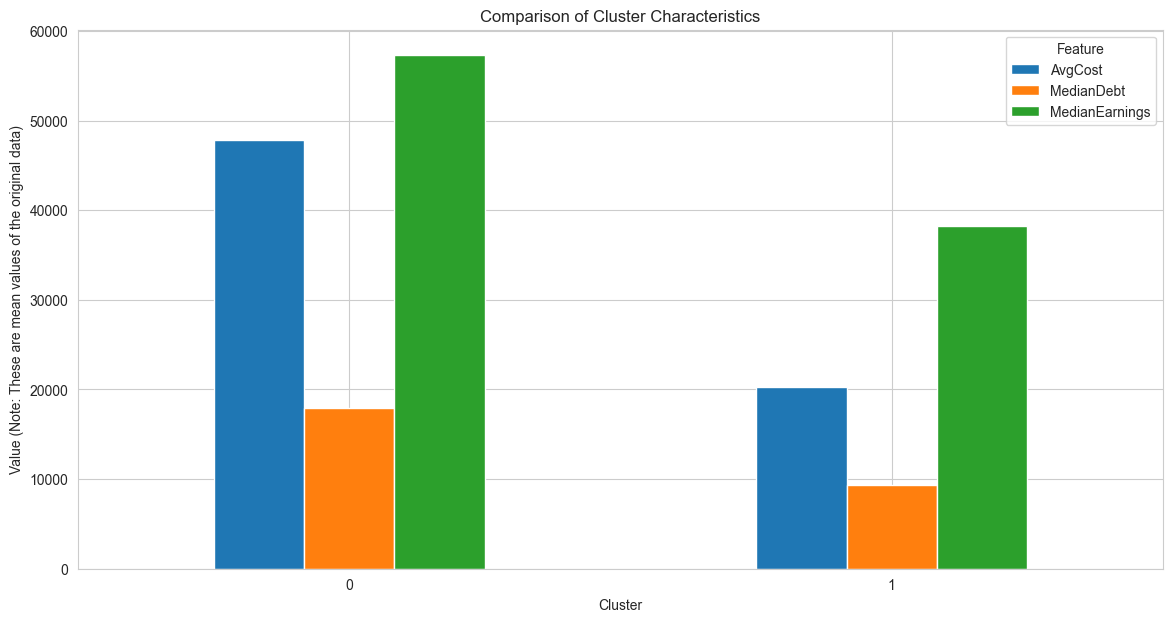


Pairplot colored by cluster label:


/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msd

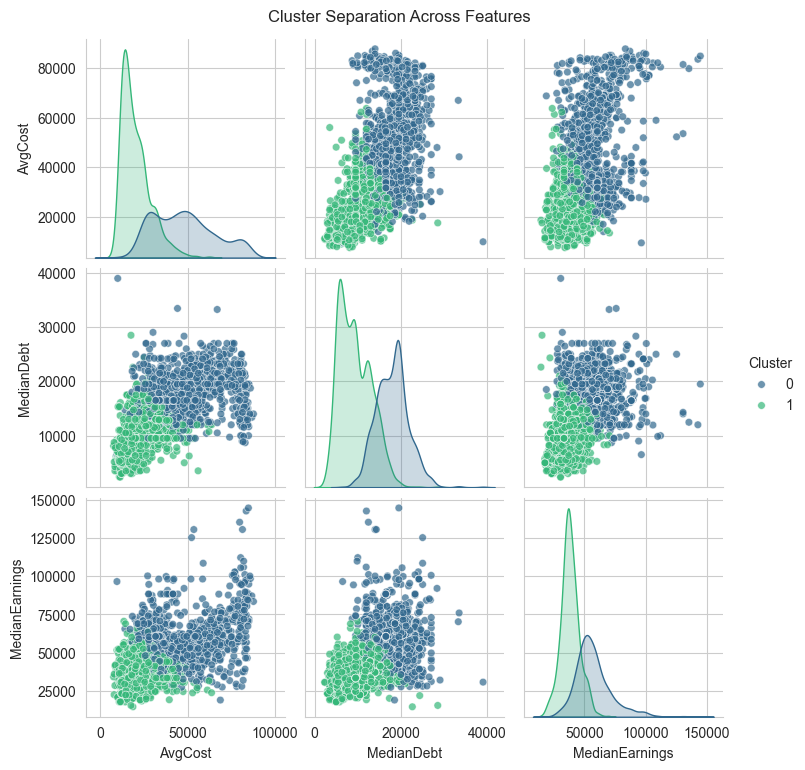

In [19]:
# Run K-Means with the optimal 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_processed['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Display the first few rows with their assigned cluster
print("Data with assigned clusters:")
display(df_processed.head())

# Analyze the characteristics of each cluster by calculating the mean of our features.
cluster_profile = df_processed.groupby('Cluster')[features_for_clustering].mean().round(2)

# Also count the number of institutions in each cluster
cluster_profile['Count'] = df_processed['Cluster'].value_counts()
cluster_profile = cluster_profile.sort_values(by='MedianEarnings', ascending=False)


print("\nCluster Profiles (mean values for each feature):")
display(cluster_profile)


# Visualize the cluster profiles to easily compare them
cluster_profile.drop('Count', axis=1).plot(kind='bar', figsize=(14, 7))
plt.title('Comparison of Cluster Characteristics')
plt.ylabel('Value (Note: These are mean values of the original data)')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()

# Create a pairplot colored by cluster to see the separation in multi-dimensional space
print("\nPairplot colored by cluster label:")
sns.pairplot(df_processed, hue='Cluster', vars=features_for_clustering, palette='viridis', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Cluster Separation Across Features', y=1.02)
plt.show()

## 6. Conclusion & Interpretation

Based on the analysis, we have successfully segmented the universities into 2 distinct groups.